In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings

warnings.filterwarnings('ignore')

In [10]:

# --- Step 2: Loading the Data ---
# We load the raw dataset and inspect its initial state.

try:
    file_path = 'Mobiles_Dataset.csv'
    df = pd.read_csv(file_path, encoding='latin1')
    print("Dataset loaded successfully.")
    print("\n--- Initial Data Overview ---")
    print(df.head())
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    df = None

Dataset loaded successfully.

--- Initial Data Overview ---
  Company Name            Model Name Mobile Weight  RAM Front Camera  \
0        Apple       iPhone 16 128GB          174g  6GB         12MP   
1        Apple       iPhone 16 256GB          174g  6GB         12MP   
2        Apple       iPhone 16 512GB          174g  6GB         12MP   
3        Apple  iPhone 16 Plus 128GB          203g  6GB         12MP   
4        Apple  iPhone 16 Plus 256GB          203g  6GB         12MP   

  Back Camera   Processor Battery Capacity Screen Size  \
0        48MP  A17 Bionic         3,600mAh  6.1 inches   
1        48MP  A17 Bionic         3,600mAh  6.1 inches   
2        48MP  A17 Bionic         3,600mAh  6.1 inches   
3        48MP  A17 Bionic         4,200mAh  6.7 inches   
4        48MP  A17 Bionic         4,200mAh  6.7 inches   

  Launched Price (Pakistan) Launched Price (India) Launched Price (China)  \
0               PKR 224,999             INR 79,999              CNY 5,799   
1   

In [11]:
# --- Step 3: Data Cleaning and Preprocessing ---
# This step cleans messy columns, converts all prices to USD, and creates a
# unified average USD price as the single target variable for our models. This approach is
# more stable and avoids issues like negative price predictions.

if df is not None:
    df_cleaned = df.copy()

    # 1. Rename columns for easier access
    df_cleaned.rename(columns={
        'Launched Price (Pakistan)': 'Price_PKR',
        'Launched Price (India)': 'Price_INR',
        'Launched Price (China)': 'Price_CNY',
        'Launched Price (USA)': 'Price_USA',
        'Launched Price (Dubai)': 'Price_AED'
    }, inplace=True)

    # 2. Function to extract numeric values from string columns
    def extract_numeric(series):
        return series.astype(str).str.extract(r'(\d+\.?\d*)', expand=False).astype(float)

    # 3. Clean all hardware and price columns
    cols_to_clean = [
        'Mobile Weight', 'RAM', 'Front Camera', 'Back Camera', 'Battery Capacity',
        'Screen Size', 'Price_PKR', 'Price_INR', 'Price_CNY', 'Price_USA', 'Price_AED'
    ]
    for col in cols_to_clean:
        if col in df_cleaned.columns:
            df_cleaned[col] = extract_numeric(df_cleaned[col])

    # 4. Currency Conversion to USD
    # Rates are approximate based on recent data.
    conversion_rates = {
        'Price_PKR': 0.00355, # 1 PKR to USD
        'Price_INR': 0.0113,  # 1 INR to USD
        'Price_CNY': 0.1398,  # 1 CNY to USD
        'Price_AED': 0.2723   # 1 AED to USD
    }

    df_cleaned['Price_USD_from_PKR'] = df_cleaned['Price_PKR'] * conversion_rates['Price_PKR']
    df_cleaned['Price_USD_from_INR'] = df_cleaned['Price_INR'] * conversion_rates['Price_INR']
    df_cleaned['Price_USD_from_CNY'] = df_cleaned['Price_CNY'] * conversion_rates['Price_CNY']
    df_cleaned['Price_USD_from_AED'] = df_cleaned['Price_AED'] * conversion_rates['Price_AED']

    # 5. Create a single, robust USD price target by averaging available prices
    # This handles regional price differences and missing values gracefully.
    usd_price_cols = ['Price_USA', 'Price_USD_from_PKR', 'Price_USD_from_INR', 'Price_USD_from_CNY', 'Price_USD_from_AED']
    df_cleaned['Price_USD_Avg'] = df_cleaned[usd_price_cols].mean(axis=1)

    # 6. Final Cleanup
    df_cleaned.drop_duplicates(inplace=True)
    df_cleaned.dropna(subset=['Price_USD_Avg'], inplace=True) # Drop rows where no price could be determined

    # Drop original and intermediate price columns to prevent data leakage
    original_price_cols = ['Price_PKR', 'Price_INR', 'Price_CNY', 'Price_USA', 'Price_AED'] + usd_price_cols
    df_cleaned.drop(columns=original_price_cols, inplace=True, errors='ignore')

    print("\n--- Data After Cleaning and USD Conversion ---")
    print(df_cleaned.head())
    df_cleaned.info()


--- Data After Cleaning and USD Conversion ---
  Company Name            Model Name  Mobile Weight  RAM  Front Camera  \
0        Apple       iPhone 16 128GB          174.0  6.0          12.0   
1        Apple       iPhone 16 256GB          174.0  6.0          12.0   
2        Apple       iPhone 16 512GB          174.0  6.0          12.0   
3        Apple  iPhone 16 Plus 128GB          203.0  6.0          12.0   
4        Apple  iPhone 16 Plus 256GB          203.0  6.0          12.0   

   Back Camera   Processor  Battery Capacity  Screen Size  Launched Year  \
0         48.0  A17 Bionic               3.0          6.1           2024   
1         48.0  A17 Bionic               3.0          6.1           2024   
2         48.0  A17 Bionic               3.0          6.1           2024   
3         48.0  A17 Bionic               4.0          6.7           2024   
4         48.0  A17 Bionic               4.0          6.7           2024   

   Price_USD_Avg  
0      160.38630  
1      170.4


--- Generating Visualizations for EDA ---


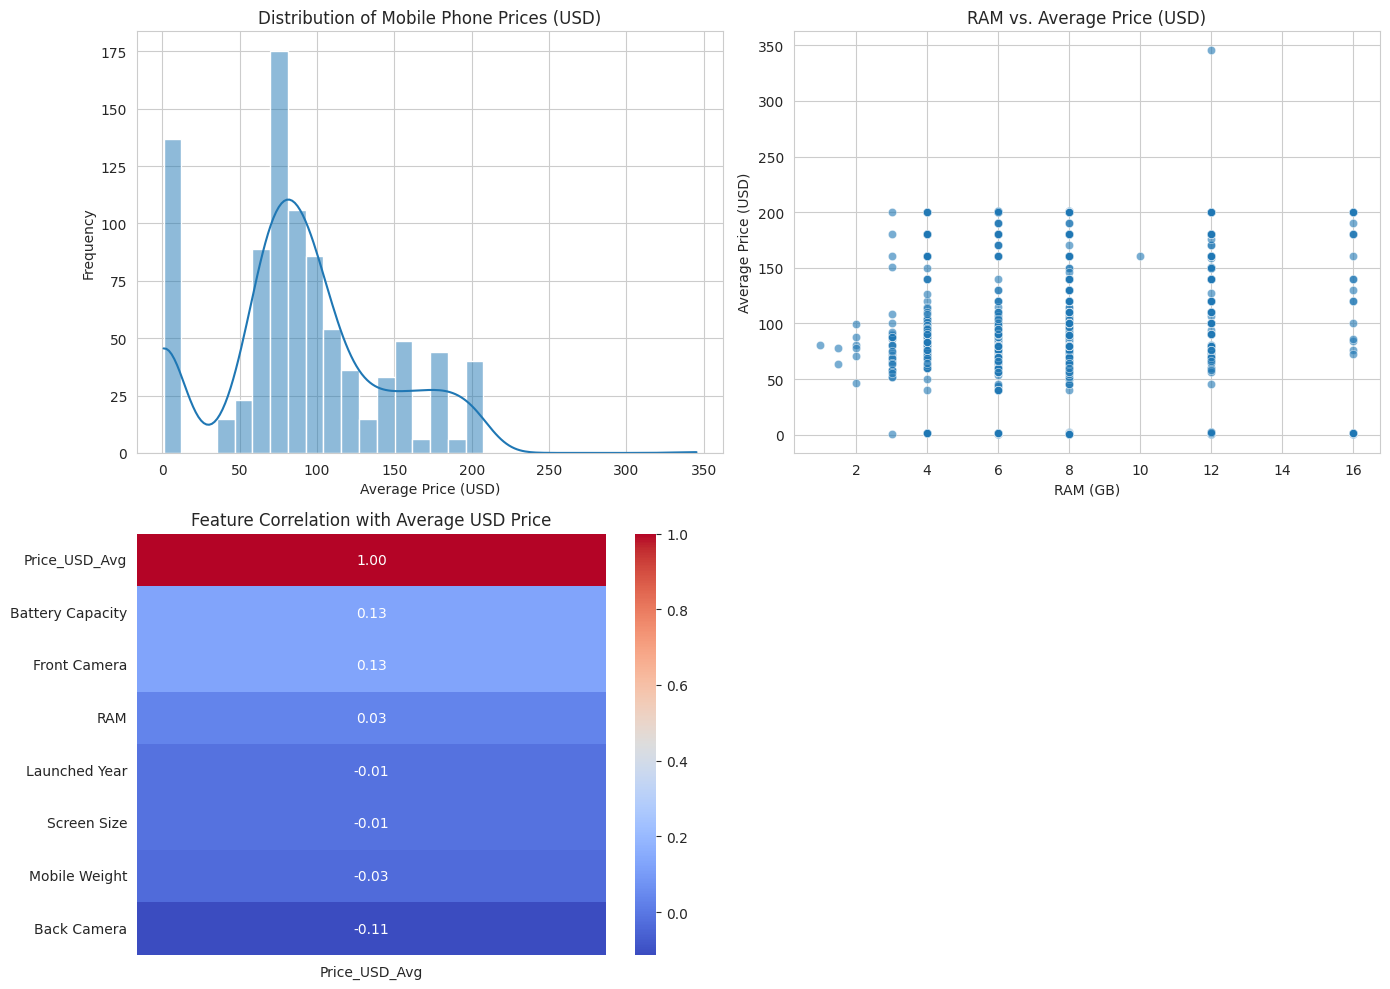

In [12]:

# --- Step 4: Exploratory Data Analysis (EDA) ---
#Visual analysis of the cleaned data with the new unified USD price target.

if df_cleaned is not None:
    print("\n--- Generating Visualizations for EDA ---")
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 10))

    # 1. Distribution of Average USD Prices
    plt.subplot(2, 2, 1)
    sns.histplot(df_cleaned['Price_USD_Avg'], kde=True, bins=30)
    plt.title('Distribution of Mobile Phone Prices (USD)')
    plt.xlabel('Average Price (USD)')
    plt.ylabel('Frequency')

    # 2. RAM vs. Average Price
    plt.subplot(2, 2, 2)
    sns.scatterplot(data=df_cleaned, x='RAM', y='Price_USD_Avg', alpha=0.6)
    plt.title('RAM vs. Average Price (USD)')
    plt.xlabel('RAM (GB)')
    plt.ylabel('Average Price (USD)')

    # 3. Correlation Heatmap
    plt.subplot(2, 2, 3)
    numeric_cols = df_cleaned.select_dtypes(include=np.number)
    correlation_matrix = numeric_cols.corr()
    sns.heatmap(correlation_matrix[['Price_USD_Avg']].sort_values(by='Price_USD_Avg', ascending=False),
                annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Feature Correlation with Average USD Price')

    plt.tight_layout()
    plt.show()

In [13]:
# --- Step 5: Model Preparation ---
# Selecting features (X) and the single target (y), encoding categorical data,
# and splitting into train/test sets.

if df_cleaned is not None:
    features = ['Mobile Weight', 'RAM', 'Front Camera', 'Back Camera', 'Battery Capacity', 'Screen Size', 'Launched Year', 'Company Name']
    target = 'Price_USD_Avg'

    X = df_cleaned[features]
    y = df_cleaned[target]

    X = pd.get_dummies(X, columns=['Company Name'], drop_first=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("\n--- Model Preparation Complete ---")



--- Model Preparation Complete ---


In [21]:
# --- Step 6: Training and Comparing Multiple Models ---
# We train three different models and evaluate their performance using
# Root Mean Squared Error (RMSE) and R-squared to find the most accurate one for
# predicting the unified USD price.

if df_cleaned is not None:
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }

    results = []
    print("\n--- Training and Evaluating Models ---")
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results.append({'Model': name, 'RMSE (USD)': rmse, 'R-squared': r2})

    results_df = pd.DataFrame(results)
gb_model=GradientBoostingRegressor(n_estimators=100, random_state=42)


--- Training and Evaluating Models ---


In [15]:
results_df

,Model,RMSE (USD),R-squared
0,Linear Regression,54.283842,0.123759
1,Random Forest,51.540489,0.210087
2,Gradient Boosting,50.005688,0.256431



--- Model Performance Comparison ---
               Model  RMSE (USD)  R-squared
2  Gradient Boosting   50.005688   0.256431
1      Random Forest   51.540489   0.210087
0  Linear Regression   54.283842   0.123759


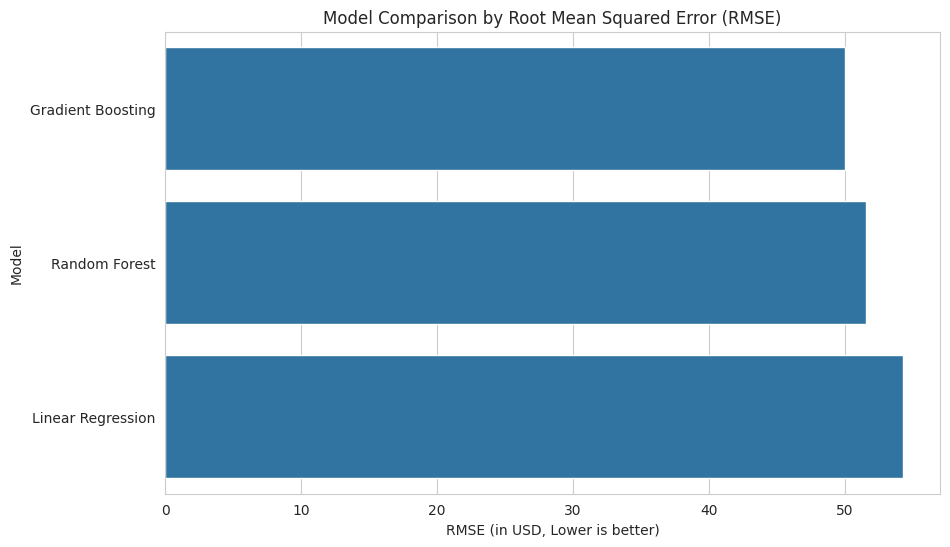


--- Final Analysis ---
Based on the results, Gradient Boosting is the best-performing model with the lowest prediction error.

Limitations of other models:
- Linear Regression: This model assumes a simple linear relationship between features and price, which is often not true for complex products like phones, leading to higher error.
- Random Forest: A strong performer, but Gradient Boosting's method of sequentially building trees to correct errors often gives it a slight edge in accuracy for this type of dataset.


In [16]:
# --- Step 7: Model Comparison and Analysis ---
# We display the performance metrics in a table and a bar chart for easy comparison.
# We also discuss the limitations of the models.
if 'results_df' in locals():
    print("\n--- Model Performance Comparison ---")
    print(results_df.sort_values(by='RMSE (USD)'))

    plt.figure(figsize=(10, 6))
    sns.barplot(x='RMSE (USD)', y='Model', data=results_df.sort_values(by='RMSE (USD)'))
    plt.title('Model Comparison by Root Mean Squared Error (RMSE)')
    plt.xlabel('RMSE (in USD, Lower is better)')
    plt.show()

    print("\n--- Final Analysis ---")
    best_model_name = results_df.loc[results_df['RMSE (USD)'].idxmin()]['Model']
    print(f"Based on the results, {best_model_name} is the best-performing model with the lowest prediction error.")
    print("\nLimitations of other models:")
    print("- Linear Regression: This model assumes a simple linear relationship between features and price, which is often not true for complex products like phones, leading to higher error.")
    print("- Random Forest: A strong performer, but Gradient Boosting's method of sequentially building trees to correct errors often gives it a slight edge in accuracy for this type of dataset.")

    best_model = models[best_model_name]

In [17]:
# --- Step 8: Predicting Future Prices and Converting Currencies ---
# I use my best model to predict the price of a hypothetical phone in USD.
# Then, we convert this single USD prediction back into the five local currencies, ensuring
# consistent and realistic price estimates for all countries.

if 'best_model' in locals():
    print(f"\n--- Future Price Prediction with {best_model_name} ---")
    # Example: predicting a Samsung phone
    new_phone_specs = {
        'Mobile Weight': 190, 'RAM': 12, 'Front Camera': 32, 'Back Camera': 108,
        'Battery Capacity': 5000, 'Screen Size': 67, 'Launched Year': 2025,
        'Company Name_Samsung': 1
    }

    new_phone_df = pd.DataFrame([new_phone_specs])
    model_columns = X_train.columns
    new_phone_aligned = new_phone_df.reindex(columns=model_columns, fill_value=0)

    predicted_price_usd = best_model.predict(new_phone_aligned)[0]

    # Inverse conversion rates to show price in local currencies
    inv_rates = {
        'PKR': 1 / 0.00355,
        'INR': 1 / 0.0113,
        'CNY': 1 / 0.1398,
        'AED': 1 / 0.2723
    }

    print(f"\nHypothetical Phone Specs:\n{new_phone_df.T.to_string(header=False)}")
    print("\n--- Predicted Prices (Converted from USD) ---")
    print(f"Price in USA (USD):        ${predicted_price_usd:,.2f}")
    print(f"Price in Pakistan (PKR): Rs. {(predicted_price_usd * inv_rates['PKR']):,.2f}")
    print(f"Price in India (INR):      ₹{(predicted_price_usd * inv_rates['INR']):,.2f}")
    print(f"Price in China (CNY):      ¥{(predicted_price_usd * inv_rates['CNY']):,.2f}")
    print(f"Price in Dubai (AED):      Dhs. {(predicted_price_usd * inv_rates['AED']):,.2f}")



--- Future Price Prediction with Gradient Boosting ---

Hypothetical Phone Specs:
Mobile Weight          190
RAM                     12
Front Camera            32
Back Camera            108
Battery Capacity      5000
Screen Size             67
Launched Year         2025
Company Name_Samsung     1

--- Predicted Prices (Converted from USD) ---
Price in USA (USD):        $29.23
Price in Pakistan (PKR): Rs. 8,232.75
Price in India (INR):      ₹2,586.40
Price in China (CNY):      ¥209.06
Price in Dubai (AED):      Dhs. 107.33


In [19]:
# --- Save the Cleaned Data to CSV ---
#
# Assuming your final cleaned DataFrame is called 'cleaned_df'
# This will save the data to a file named 'cleaned_mobile_data.csv' in the same folder.
# The index=False part prevents pandas from writing the row numbers into the file.

print("Saving the cleaned data to a CSV file...")
df_cleaned.to_csv('cleaned_mobile_data.csv', index=False)
print("✅ Successfully saved cleaned_mobile_data.csv")

Saving the cleaned data to a CSV file...
✅ Successfully saved cleaned_mobile_data.csv


In [22]:
import pickle

# --- Save the Trained Model using Pickle ---
#
# Assuming your trained Gradient Boosting model is named 'gb_model'
# This will save the model to a file named 'gb_model.pkl'

print("\nSaving the trained Gradient Boosting model...")
with open('gb_model.pkl', 'wb') as file:
    pickle.dump(gb_model, file)

print("✅ Model saved successfully as gb_model.pkl")


Saving the trained Gradient Boosting model...
✅ Model saved successfully as gb_model.pkl
